In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]='1'

In [2]:
genrator = models.Sequential()
genrator.add(layers.Dense(7*7*128,input_dim=100,
                         activation=layers.LeakyReLU(0.2)))#하이퍼 파라미팅
genrator.add(layers.BatchNormalization())
genrator.add(layers.Reshape((7,7,128)))
genrator.add(layers.UpSampling2D())
genrator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
genrator.add(layers.BatchNormalization())
genrator.add(layers.Activation(layers.LeakyReLU(0.2)))
genrator.add(layers.UpSampling2D())
genrator.add(layers.Conv2D(1, kernel_size=5, padding='same',activation='tanh'))

In [3]:
genrator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [4]:
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, input_shape=(28,28,1), 
                                strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False #Non-trainable params
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [5]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(genrator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [6]:
if not os.path.exists('../data/gan_image'):
    os.mkdir('../data/gan_image')
    
def gan_train(epoch, batch_size, saving_interval):
    (X_train,_),(_, _)=mnist.load_data()
    X_train= X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train= (X_train - 127.5)/127.5
    
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs=X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        noise= np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = genrator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = genrator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("../data/gan_image/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 171ms/step
epoch:0  d_loss:0.7111  g_loss:0.4666
1/1 [==============================] - 0s 31ms/step
epoch:1  d_loss:0.4896  g_loss:0.1554
1/1 [==============================] - 0s 31ms/step
epoch:2  d_loss:0.4720  g_loss:0.0404
1/1 [==============================] - 0s 24ms/step
epoch:3  d_loss:0.5157  g_loss:0.0268
1/1 [==============================] - 0s 26ms/step
epoch:4  d_loss:0.5236  g_loss:0.0511
1/1 [==============================] - 0s 30ms/step
epoch:5  d_loss:0.5012  g_loss:0.1588
1/1 [==============================] - 0s 29ms/step
epoch:6  d_loss:0.4591  g_loss:0.3870
1/1 [==============================] - 0s 31ms/step
epoch:7  d_loss:0.4629  g_loss:0.6174
1/1 [==============================] - 0s 47ms/step
epoch:8  d_loss:0.4760  g_loss:0.7445
1/1 [==============================] - 0s 22ms/step
epoch:9  d_loss:0.4473  g_loss:0.7909
1/1 [==============================] - 0s 27ms/step
epoch:10  d_loss:0.4198  g_loss:0.8500
1/1 [===

epoch:89  d_loss:0.4344  g_loss:1.5550
1/1 [==============================] - 0s 27ms/step
epoch:90  d_loss:0.3304  g_loss:2.1015
1/1 [==============================] - 0s 30ms/step
epoch:91  d_loss:0.3518  g_loss:2.1384
1/1 [==============================] - 0s 29ms/step
epoch:92  d_loss:0.3736  g_loss:1.8613
1/1 [==============================] - 0s 16ms/step
epoch:93  d_loss:0.4078  g_loss:1.9604
1/1 [==============================] - 0s 16ms/step
epoch:94  d_loss:0.4236  g_loss:1.9462
1/1 [==============================] - 0s 30ms/step
epoch:95  d_loss:0.5967  g_loss:1.6503
1/1 [==============================] - 0s 19ms/step
epoch:96  d_loss:0.7612  g_loss:1.5588
1/1 [==============================] - 0s 23ms/step
epoch:97  d_loss:0.5945  g_loss:1.7428
1/1 [==============================] - 0s 31ms/step
epoch:98  d_loss:0.6291  g_loss:1.5635
1/1 [==============================] - 0s 30ms/step
epoch:99  d_loss:0.6835  g_loss:1.4478
1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 30ms/step
epoch:179  d_loss:0.5136  g_loss:1.5012
1/1 [==============================] - 0s 30ms/step
epoch:180  d_loss:0.5918  g_loss:1.4114
1/1 [==============================] - 0s 24ms/step
epoch:181  d_loss:0.4680  g_loss:1.7752
1/1 [==============================] - 0s 23ms/step
epoch:182  d_loss:0.5436  g_loss:1.6776
1/1 [==============================] - 0s 17ms/step
epoch:183  d_loss:0.6148  g_loss:1.5977
1/1 [==============================] - 0s 22ms/step
epoch:184  d_loss:0.6225  g_loss:1.5871
1/1 [==============================] - 0s 27ms/step
epoch:185  d_loss:0.7031  g_loss:1.2100
1/1 [==============================] - 0s 31ms/step
epoch:186  d_loss:0.6857  g_loss:1.3316
1/1 [==============================] - 0s 19ms/step
epoch:187  d_loss:0.5743  g_loss:1.4713
1/1 [==============================] - 0s 23ms/step
epoch:188  d_loss:0.5050  g_loss:1.8084
1/1 [==============================] - 0s 31ms/step
epoch:189  d_loss:0.5524  g_

1/1 [==============================] - 0s 30ms/step
epoch:267  d_loss:0.5706  g_loss:1.3537
1/1 [==============================] - 0s 15ms/step
epoch:268  d_loss:0.5306  g_loss:1.2616
1/1 [==============================] - 0s 19ms/step
epoch:269  d_loss:0.4330  g_loss:1.3056
1/1 [==============================] - 0s 29ms/step
epoch:270  d_loss:0.4544  g_loss:1.7175
1/1 [==============================] - 0s 24ms/step
epoch:271  d_loss:0.4675  g_loss:1.3858
1/1 [==============================] - 0s 24ms/step
epoch:272  d_loss:0.4205  g_loss:1.5518
1/1 [==============================] - 0s 31ms/step
epoch:273  d_loss:0.4978  g_loss:1.4602
1/1 [==============================] - 0s 29ms/step
epoch:274  d_loss:0.5240  g_loss:1.1805
1/1 [==============================] - 0s 20ms/step
epoch:275  d_loss:0.4401  g_loss:1.3232
1/1 [==============================] - 0s 31ms/step
epoch:276  d_loss:0.5090  g_loss:1.4148
1/1 [==============================] - 0s 28ms/step
epoch:277  d_loss:0.4924  g_

1/1 [==============================] - 0s 30ms/step
epoch:356  d_loss:0.6009  g_loss:1.8318
1/1 [==============================] - 0s 24ms/step
epoch:357  d_loss:0.4476  g_loss:1.4160
1/1 [==============================] - 0s 25ms/step
epoch:358  d_loss:0.3585  g_loss:1.8715
1/1 [==============================] - 0s 17ms/step
epoch:359  d_loss:0.3892  g_loss:1.8548
1/1 [==============================] - 0s 23ms/step
epoch:360  d_loss:0.3285  g_loss:2.8968
1/1 [==============================] - 0s 27ms/step
epoch:361  d_loss:0.4518  g_loss:2.5856
1/1 [==============================] - 0s 29ms/step
epoch:362  d_loss:0.5357  g_loss:2.5970
1/1 [==============================] - 0s 31ms/step
epoch:363  d_loss:0.4590  g_loss:1.7451
1/1 [==============================] - 0s 25ms/step
epoch:364  d_loss:0.3918  g_loss:1.7555
1/1 [==============================] - 0s 31ms/step
epoch:365  d_loss:0.3903  g_loss:1.8166
1/1 [==============================] - 0s 29ms/step
epoch:366  d_loss:0.2791  g_

1/1 [==============================] - 0s 28ms/step
epoch:444  d_loss:0.2502  g_loss:2.3124
1/1 [==============================] - 0s 31ms/step
epoch:445  d_loss:0.3111  g_loss:2.4327
1/1 [==============================] - 0s 30ms/step
epoch:446  d_loss:0.2658  g_loss:2.4617
1/1 [==============================] - 0s 30ms/step
epoch:447  d_loss:0.2970  g_loss:2.5013
1/1 [==============================] - 0s 24ms/step
epoch:448  d_loss:0.2737  g_loss:2.5544
1/1 [==============================] - 0s 31ms/step
epoch:449  d_loss:0.4361  g_loss:2.4981
1/1 [==============================] - 0s 24ms/step
epoch:450  d_loss:0.2139  g_loss:2.5788
1/1 [==============================] - 0s 22ms/step
epoch:451  d_loss:0.2077  g_loss:2.9013
1/1 [==============================] - 0s 24ms/step
epoch:452  d_loss:0.2514  g_loss:2.8416
1/1 [==============================] - 0s 31ms/step
epoch:453  d_loss:0.2972  g_loss:3.1572
1/1 [==============================] - 0s 29ms/step
epoch:454  d_loss:0.3009  g_

1/1 [==============================] - 0s 31ms/step
epoch:533  d_loss:0.2681  g_loss:1.8386
1/1 [==============================] - 0s 29ms/step
epoch:534  d_loss:0.3576  g_loss:3.0523
1/1 [==============================] - 0s 28ms/step
epoch:535  d_loss:0.3470  g_loss:3.7513
1/1 [==============================] - 0s 30ms/step
epoch:536  d_loss:0.2949  g_loss:3.7129
1/1 [==============================] - 0s 29ms/step
epoch:537  d_loss:0.2708  g_loss:3.0851
1/1 [==============================] - 0s 24ms/step
epoch:538  d_loss:0.2492  g_loss:2.7717
1/1 [==============================] - 0s 23ms/step
epoch:539  d_loss:0.2560  g_loss:2.6906
1/1 [==============================] - 0s 31ms/step
epoch:540  d_loss:0.1742  g_loss:3.3020
1/1 [==============================] - 0s 29ms/step
epoch:541  d_loss:0.1216  g_loss:2.8333
1/1 [==============================] - 0s 30ms/step
epoch:542  d_loss:0.2076  g_loss:2.3956
1/1 [==============================] - 0s 31ms/step
epoch:543  d_loss:0.3317  g_

1/1 [==============================] - 0s 31ms/step
epoch:621  d_loss:0.3773  g_loss:2.4493
1/1 [==============================] - 0s 16ms/step
epoch:622  d_loss:0.4909  g_loss:2.6980
1/1 [==============================] - 0s 30ms/step
epoch:623  d_loss:0.8635  g_loss:2.0026
1/1 [==============================] - 0s 30ms/step
epoch:624  d_loss:0.5000  g_loss:1.9084
1/1 [==============================] - 0s 17ms/step
epoch:625  d_loss:0.4988  g_loss:1.4342
1/1 [==============================] - 0s 30ms/step
epoch:626  d_loss:0.8760  g_loss:1.2754
1/1 [==============================] - 0s 27ms/step
epoch:627  d_loss:0.4110  g_loss:1.6420
1/1 [==============================] - 0s 31ms/step
epoch:628  d_loss:0.7239  g_loss:1.4191
1/1 [==============================] - 0s 31ms/step
epoch:629  d_loss:0.3694  g_loss:1.7035
1/1 [==============================] - 0s 28ms/step
epoch:630  d_loss:0.4734  g_loss:1.5064
1/1 [==============================] - 0s 31ms/step
epoch:631  d_loss:0.4896  g_

1/1 [==============================] - 0s 16ms/step
epoch:710  d_loss:0.3969  g_loss:2.2110
1/1 [==============================] - 0s 31ms/step
epoch:711  d_loss:0.3622  g_loss:2.4114
1/1 [==============================] - 0s 25ms/step
epoch:712  d_loss:0.4190  g_loss:2.6487
1/1 [==============================] - 0s 26ms/step
epoch:713  d_loss:0.2323  g_loss:2.6645
1/1 [==============================] - 0s 30ms/step
epoch:714  d_loss:0.3741  g_loss:2.4372
1/1 [==============================] - 0s 29ms/step
epoch:715  d_loss:0.2937  g_loss:2.0238
1/1 [==============================] - 0s 19ms/step
epoch:716  d_loss:0.2906  g_loss:2.0527
1/1 [==============================] - 0s 30ms/step
epoch:717  d_loss:0.3805  g_loss:2.1436
1/1 [==============================] - 0s 28ms/step
epoch:718  d_loss:0.3203  g_loss:1.8945
1/1 [==============================] - 0s 29ms/step
epoch:719  d_loss:0.2442  g_loss:2.1806
1/1 [==============================] - 0s 29ms/step
epoch:720  d_loss:0.2869  g_

1/1 [==============================] - 0s 30ms/step
epoch:799  d_loss:0.2512  g_loss:2.8574
1/1 [==============================] - 0s 23ms/step
epoch:800  d_loss:0.4096  g_loss:3.1902
1/1 [==============================] - 0s 16ms/step
epoch:801  d_loss:0.3069  g_loss:4.0038
1/1 [==============================] - 0s 35ms/step
epoch:802  d_loss:0.3409  g_loss:3.7848
1/1 [==============================] - 0s 24ms/step
epoch:803  d_loss:0.3440  g_loss:2.8191
1/1 [==============================] - 0s 31ms/step
epoch:804  d_loss:0.3244  g_loss:2.1879
1/1 [==============================] - 0s 30ms/step
epoch:805  d_loss:0.2471  g_loss:2.1393
1/1 [==============================] - 0s 18ms/step
epoch:806  d_loss:0.2418  g_loss:3.0837
1/1 [==============================] - 0s 31ms/step
epoch:807  d_loss:0.2267  g_loss:3.5963
1/1 [==============================] - 0s 45ms/step
epoch:808  d_loss:0.2808  g_loss:3.6032
1/1 [==============================] - 0s 31ms/step
epoch:809  d_loss:0.2791  g_

1/1 [==============================] - 0s 18ms/step
epoch:887  d_loss:0.3539  g_loss:2.9755
1/1 [==============================] - 0s 23ms/step
epoch:888  d_loss:0.2264  g_loss:3.7046
1/1 [==============================] - 0s 25ms/step
epoch:889  d_loss:0.1110  g_loss:4.4323
1/1 [==============================] - 0s 31ms/step
epoch:890  d_loss:0.1927  g_loss:3.7457
1/1 [==============================] - 0s 30ms/step
epoch:891  d_loss:0.3522  g_loss:3.9302
1/1 [==============================] - 0s 17ms/step
epoch:892  d_loss:0.2096  g_loss:3.7600
1/1 [==============================] - 0s 30ms/step
epoch:893  d_loss:0.1725  g_loss:3.9189
1/1 [==============================] - 0s 15ms/step
epoch:894  d_loss:0.1332  g_loss:3.0533
1/1 [==============================] - 0s 19ms/step
epoch:895  d_loss:0.4090  g_loss:2.2815
1/1 [==============================] - 0s 31ms/step
epoch:896  d_loss:0.2823  g_loss:2.5714
1/1 [==============================] - 0s 25ms/step
epoch:897  d_loss:0.3307  g_

1/1 [==============================] - 0s 27ms/step
epoch:976  d_loss:0.4478  g_loss:1.7563
1/1 [==============================] - 0s 30ms/step
epoch:977  d_loss:0.4093  g_loss:2.0766
1/1 [==============================] - 0s 18ms/step
epoch:978  d_loss:0.3880  g_loss:1.7636
1/1 [==============================] - 0s 22ms/step
epoch:979  d_loss:0.3574  g_loss:1.6286
1/1 [==============================] - 0s 28ms/step
epoch:980  d_loss:0.4724  g_loss:1.6021
1/1 [==============================] - 0s 30ms/step
epoch:981  d_loss:0.3981  g_loss:1.8994
1/1 [==============================] - 0s 28ms/step
epoch:982  d_loss:0.3013  g_loss:2.3566
1/1 [==============================] - 0s 14ms/step
epoch:983  d_loss:0.2912  g_loss:2.6667
1/1 [==============================] - 0s 30ms/step
epoch:984  d_loss:0.2848  g_loss:2.6788
1/1 [==============================] - 0s 25ms/step
epoch:985  d_loss:0.3429  g_loss:2.7166
1/1 [==============================] - 0s 22ms/step
epoch:986  d_loss:0.3169  g_

1/1 [==============================] - 0s 19ms/step
epoch:1064  d_loss:0.4053  g_loss:1.8301
1/1 [==============================] - 0s 22ms/step
epoch:1065  d_loss:0.4350  g_loss:1.9431
1/1 [==============================] - 0s 31ms/step
epoch:1066  d_loss:0.4637  g_loss:1.9828
1/1 [==============================] - 0s 28ms/step
epoch:1067  d_loss:0.4358  g_loss:2.7823
1/1 [==============================] - 0s 30ms/step
epoch:1068  d_loss:0.4153  g_loss:1.9441
1/1 [==============================] - 0s 30ms/step
epoch:1069  d_loss:0.3555  g_loss:2.0920
1/1 [==============================] - 0s 20ms/step
epoch:1070  d_loss:0.3459  g_loss:1.8572
1/1 [==============================] - 0s 31ms/step
epoch:1071  d_loss:0.3197  g_loss:2.0601
1/1 [==============================] - 0s 30ms/step
epoch:1072  d_loss:0.3299  g_loss:1.9235
1/1 [==============================] - 0s 30ms/step
epoch:1073  d_loss:0.2622  g_loss:2.4525
1/1 [==============================] - 0s 30ms/step
epoch:1074  d_loss

1/1 [==============================] - 0s 31ms/step
epoch:1152  d_loss:0.4903  g_loss:2.1786
1/1 [==============================] - 0s 30ms/step
epoch:1153  d_loss:0.4085  g_loss:1.9581
1/1 [==============================] - 0s 29ms/step
epoch:1154  d_loss:0.4005  g_loss:2.5411
1/1 [==============================] - 0s 30ms/step
epoch:1155  d_loss:0.3467  g_loss:2.6974
1/1 [==============================] - 0s 18ms/step
epoch:1156  d_loss:0.2840  g_loss:2.8687
1/1 [==============================] - 0s 16ms/step
epoch:1157  d_loss:0.2689  g_loss:2.6192
1/1 [==============================] - 0s 30ms/step
epoch:1158  d_loss:0.3379  g_loss:2.5946
1/1 [==============================] - 0s 24ms/step
epoch:1159  d_loss:0.4361  g_loss:2.1906
1/1 [==============================] - 0s 26ms/step
epoch:1160  d_loss:0.3666  g_loss:2.0175
1/1 [==============================] - 0s 30ms/step
epoch:1161  d_loss:0.2293  g_loss:2.6685
1/1 [==============================] - 0s 21ms/step
epoch:1162  d_loss

epoch:1239  d_loss:0.1738  g_loss:2.7023
1/1 [==============================] - 0s 31ms/step
epoch:1240  d_loss:0.2518  g_loss:2.8544
1/1 [==============================] - 0s 30ms/step
epoch:1241  d_loss:0.2530  g_loss:3.1123
1/1 [==============================] - 0s 22ms/step
epoch:1242  d_loss:0.2374  g_loss:2.5496
1/1 [==============================] - 0s 22ms/step
epoch:1243  d_loss:0.4432  g_loss:2.2695
1/1 [==============================] - 0s 30ms/step
epoch:1244  d_loss:0.2489  g_loss:2.6332
1/1 [==============================] - 0s 28ms/step
epoch:1245  d_loss:0.2645  g_loss:2.3531
1/1 [==============================] - 0s 30ms/step
epoch:1246  d_loss:0.2633  g_loss:2.9654
1/1 [==============================] - 0s 30ms/step
epoch:1247  d_loss:0.4020  g_loss:2.3534
1/1 [==============================] - 0s 16ms/step
epoch:1248  d_loss:0.4628  g_loss:2.7469
1/1 [==============================] - 0s 31ms/step
epoch:1249  d_loss:0.3127  g_loss:3.0623
1/1 [========================

1/1 [==============================] - 0s 25ms/step
epoch:1328  d_loss:0.4954  g_loss:1.8676
1/1 [==============================] - 0s 26ms/step
epoch:1329  d_loss:0.5690  g_loss:1.7289
1/1 [==============================] - 0s 27ms/step
epoch:1330  d_loss:0.4499  g_loss:1.9223
1/1 [==============================] - 0s 27ms/step
epoch:1331  d_loss:0.4243  g_loss:1.7513
1/1 [==============================] - 0s 30ms/step
epoch:1332  d_loss:0.5382  g_loss:1.8281
1/1 [==============================] - 0s 30ms/step
epoch:1333  d_loss:0.4081  g_loss:2.0929
1/1 [==============================] - 0s 30ms/step
epoch:1334  d_loss:0.5430  g_loss:1.5297
1/1 [==============================] - 0s 30ms/step
epoch:1335  d_loss:0.4543  g_loss:1.8642
1/1 [==============================] - 0s 31ms/step
epoch:1336  d_loss:0.3976  g_loss:2.0704
1/1 [==============================] - 0s 31ms/step
epoch:1337  d_loss:0.4812  g_loss:1.9650
1/1 [==============================] - 0s 26ms/step
epoch:1338  d_loss

epoch:1415  d_loss:0.3842  g_loss:1.5286
1/1 [==============================] - 0s 24ms/step
epoch:1416  d_loss:0.4832  g_loss:1.5224
1/1 [==============================] - 0s 25ms/step
epoch:1417  d_loss:0.4309  g_loss:2.1371
1/1 [==============================] - 0s 31ms/step
epoch:1418  d_loss:0.4874  g_loss:1.9675
1/1 [==============================] - 0s 24ms/step
epoch:1419  d_loss:0.5045  g_loss:1.7759
1/1 [==============================] - 0s 24ms/step
epoch:1420  d_loss:0.4394  g_loss:1.8603
1/1 [==============================] - 0s 31ms/step
epoch:1421  d_loss:0.5959  g_loss:1.8115
1/1 [==============================] - 0s 28ms/step
epoch:1422  d_loss:0.5254  g_loss:1.1653
1/1 [==============================] - 0s 31ms/step
epoch:1423  d_loss:0.4652  g_loss:1.2510
1/1 [==============================] - 0s 30ms/step
epoch:1424  d_loss:0.4399  g_loss:1.3190
1/1 [==============================] - 0s 16ms/step
epoch:1425  d_loss:0.4641  g_loss:1.8461
1/1 [========================

1/1 [==============================] - 0s 30ms/step
epoch:1504  d_loss:0.4515  g_loss:1.6430
1/1 [==============================] - 0s 24ms/step
epoch:1505  d_loss:0.4133  g_loss:1.5697
1/1 [==============================] - 0s 25ms/step
epoch:1506  d_loss:0.3426  g_loss:2.3361
1/1 [==============================] - 0s 30ms/step
epoch:1507  d_loss:0.5560  g_loss:1.6237
1/1 [==============================] - 0s 27ms/step
epoch:1508  d_loss:0.7118  g_loss:1.2967
1/1 [==============================] - 0s 27ms/step
epoch:1509  d_loss:0.3975  g_loss:1.7649
1/1 [==============================] - 0s 28ms/step
epoch:1510  d_loss:0.3744  g_loss:1.6023
1/1 [==============================] - 0s 31ms/step
epoch:1511  d_loss:0.3278  g_loss:1.8741
1/1 [==============================] - 0s 30ms/step
epoch:1512  d_loss:0.4674  g_loss:1.6387
1/1 [==============================] - 0s 30ms/step
epoch:1513  d_loss:0.3311  g_loss:2.3611
1/1 [==============================] - 0s 30ms/step
epoch:1514  d_loss

1/1 [==============================] - 0s 31ms/step
epoch:1592  d_loss:0.5492  g_loss:1.4432
1/1 [==============================] - 0s 28ms/step
epoch:1593  d_loss:0.4539  g_loss:1.3222
1/1 [==============================] - 0s 29ms/step
epoch:1594  d_loss:0.4445  g_loss:2.2642
1/1 [==============================] - 0s 30ms/step
epoch:1595  d_loss:0.6315  g_loss:1.8084
1/1 [==============================] - 0s 31ms/step
epoch:1596  d_loss:0.5268  g_loss:1.7410
1/1 [==============================] - 0s 17ms/step
epoch:1597  d_loss:0.5281  g_loss:1.7753
1/1 [==============================] - 0s 30ms/step
epoch:1598  d_loss:0.5736  g_loss:1.3783
1/1 [==============================] - 0s 24ms/step
epoch:1599  d_loss:0.5778  g_loss:1.6329
1/1 [==============================] - 0s 23ms/step
epoch:1600  d_loss:0.8280  g_loss:1.4662
1/1 [==============================] - 0s 31ms/step
epoch:1601  d_loss:0.6116  g_loss:1.4838
1/1 [==============================] - 0s 31ms/step
epoch:1602  d_loss

epoch:1679  d_loss:0.4367  g_loss:1.9514
1/1 [==============================] - 0s 17ms/step
epoch:1680  d_loss:0.4331  g_loss:1.9611
1/1 [==============================] - 0s 17ms/step
epoch:1681  d_loss:0.4504  g_loss:1.8380
1/1 [==============================] - 0s 18ms/step
epoch:1682  d_loss:0.4971  g_loss:1.4998
1/1 [==============================] - 0s 31ms/step
epoch:1683  d_loss:0.5688  g_loss:1.7579
1/1 [==============================] - 0s 25ms/step
epoch:1684  d_loss:0.6335  g_loss:1.5242
1/1 [==============================] - 0s 26ms/step
epoch:1685  d_loss:0.5618  g_loss:1.4362
1/1 [==============================] - 0s 21ms/step
epoch:1686  d_loss:0.5370  g_loss:1.7455
1/1 [==============================] - 0s 23ms/step
epoch:1687  d_loss:0.4539  g_loss:1.8077
1/1 [==============================] - 0s 25ms/step
epoch:1688  d_loss:0.4303  g_loss:1.8711
1/1 [==============================] - 0s 30ms/step
epoch:1689  d_loss:0.6694  g_loss:1.4332
1/1 [========================

1/1 [==============================] - 0s 16ms/step
epoch:1768  d_loss:0.5344  g_loss:1.1338
1/1 [==============================] - 0s 28ms/step
epoch:1769  d_loss:0.4974  g_loss:1.4032
1/1 [==============================] - 0s 31ms/step
epoch:1770  d_loss:0.4670  g_loss:1.5289
1/1 [==============================] - 0s 16ms/step
epoch:1771  d_loss:0.3950  g_loss:2.1247
1/1 [==============================] - 0s 19ms/step
epoch:1772  d_loss:0.4514  g_loss:2.0453
1/1 [==============================] - 0s 31ms/step
epoch:1773  d_loss:0.5024  g_loss:2.3198
1/1 [==============================] - 0s 23ms/step
epoch:1774  d_loss:0.3398  g_loss:1.9325
1/1 [==============================] - 0s 18ms/step
epoch:1775  d_loss:0.3006  g_loss:1.9199
1/1 [==============================] - 0s 31ms/step
epoch:1776  d_loss:0.3701  g_loss:1.6489
1/1 [==============================] - 0s 22ms/step
epoch:1777  d_loss:0.4448  g_loss:1.5700
1/1 [==============================] - 0s 23ms/step
epoch:1778  d_loss

epoch:1855  d_loss:0.3731  g_loss:1.9094
1/1 [==============================] - 0s 21ms/step
epoch:1856  d_loss:0.4530  g_loss:1.6570
1/1 [==============================] - 0s 23ms/step
epoch:1857  d_loss:0.5372  g_loss:1.6632
1/1 [==============================] - 0s 33ms/step
epoch:1858  d_loss:0.3609  g_loss:1.5932
1/1 [==============================] - 0s 23ms/step
epoch:1859  d_loss:0.5346  g_loss:1.3292
1/1 [==============================] - 0s 23ms/step
epoch:1860  d_loss:0.4382  g_loss:1.4371
1/1 [==============================] - 0s 30ms/step
epoch:1861  d_loss:0.6213  g_loss:1.5659
1/1 [==============================] - 0s 21ms/step
epoch:1862  d_loss:0.5204  g_loss:1.5275
1/1 [==============================] - 0s 23ms/step
epoch:1863  d_loss:0.5261  g_loss:1.6089
1/1 [==============================] - 0s 33ms/step
epoch:1864  d_loss:0.6072  g_loss:1.4688
1/1 [==============================] - 0s 24ms/step
epoch:1865  d_loss:0.7408  g_loss:1.0771
1/1 [========================

1/1 [==============================] - 0s 31ms/step
epoch:1944  d_loss:0.4383  g_loss:1.4551
1/1 [==============================] - 0s 80ms/step
epoch:1945  d_loss:0.4677  g_loss:1.5379
1/1 [==============================] - 0s 31ms/step
epoch:1946  d_loss:0.3175  g_loss:1.5250
1/1 [==============================] - 0s 24ms/step
epoch:1947  d_loss:0.5256  g_loss:1.3244
1/1 [==============================] - 0s 19ms/step
epoch:1948  d_loss:0.6591  g_loss:1.0270
1/1 [==============================] - 0s 30ms/step
epoch:1949  d_loss:0.4487  g_loss:1.3609
1/1 [==============================] - 0s 37ms/step
epoch:1950  d_loss:0.6348  g_loss:1.4169
1/1 [==============================] - 0s 47ms/step
epoch:1951  d_loss:0.5868  g_loss:1.2718
1/1 [==============================] - 0s 94ms/step
epoch:1952  d_loss:0.5799  g_loss:1.2202
1/1 [==============================] - 0s 62ms/step
epoch:1953  d_loss:0.5735  g_loss:1.6742
1/1 [==============================] - 0s 35ms/step
epoch:1954  d_loss

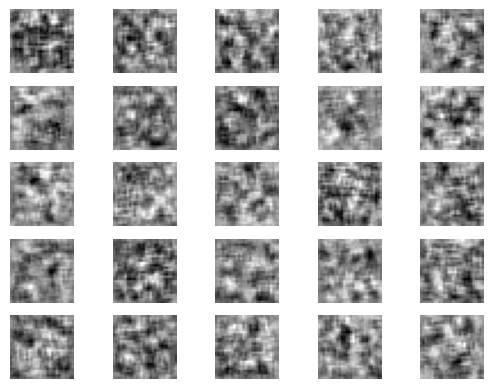

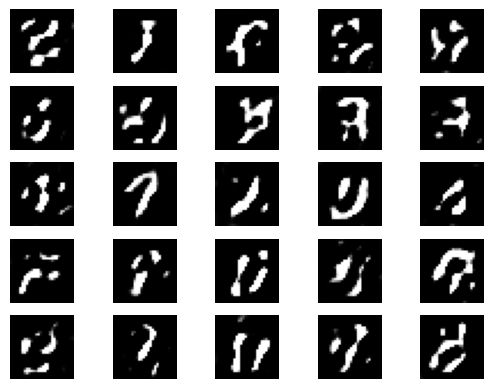

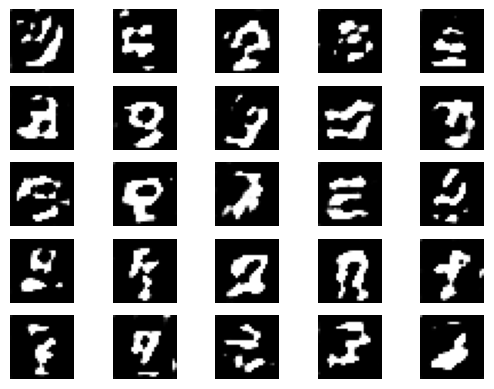

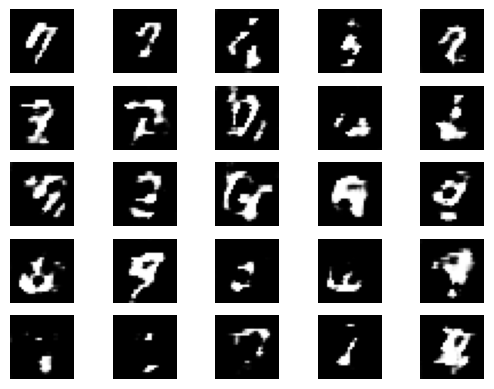

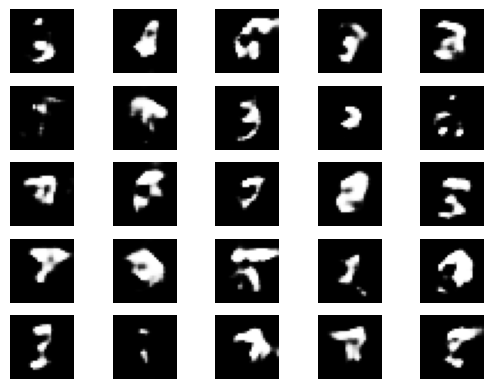

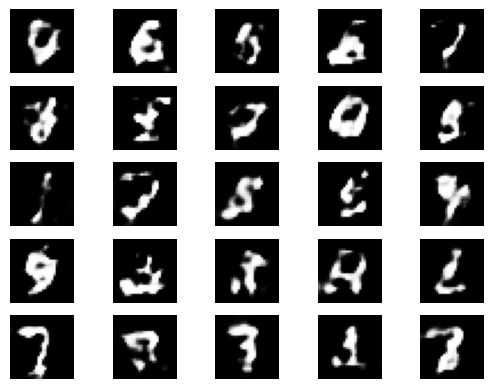

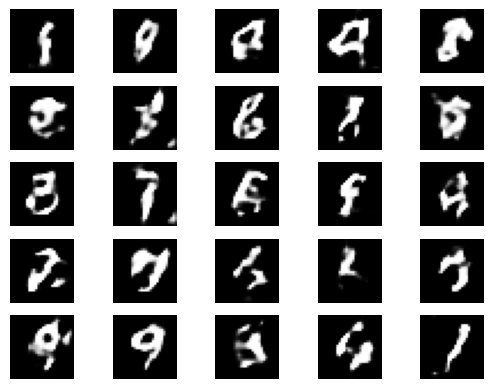

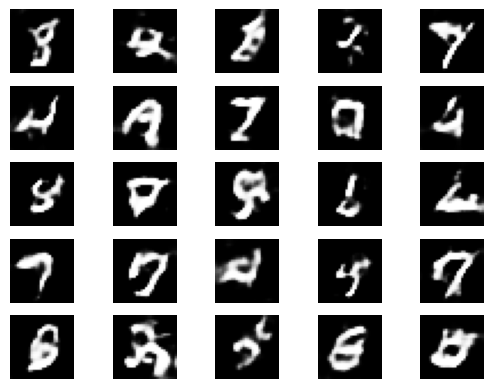

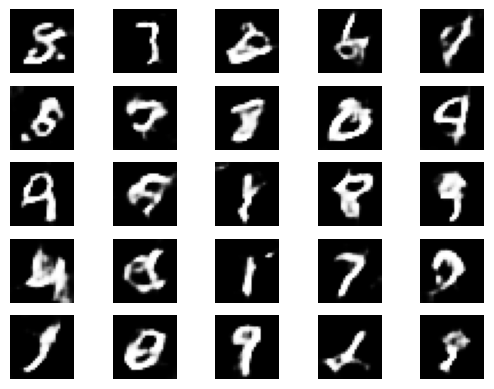

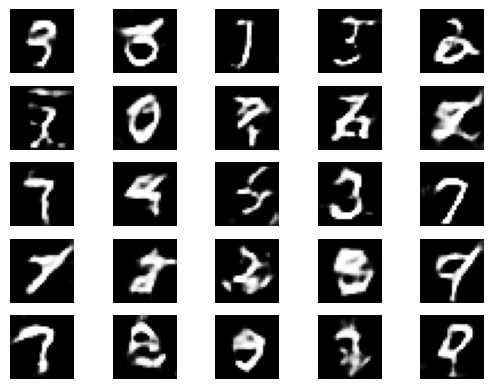

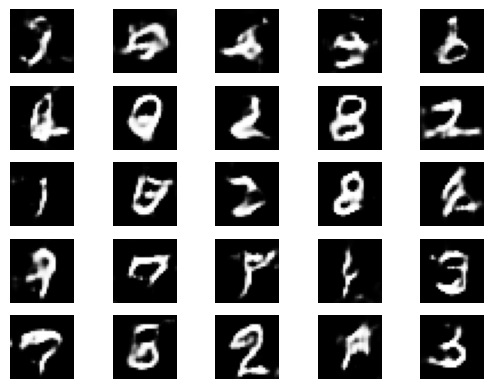

In [7]:
gan_train(2001, 32, 200)